# Alpha lifetime

An script to compute alpha lifetime.

In [1]:
from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import sys
import os
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import textwrap
import numpy as np
import pandas as pd
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from invisible_cities.database import load_db
import invisible_cities.core.system_of_units_c as SystemOfUnits
from invisible_cities.core.core_functions import timefunc, flat
import invisible_cities.core.fit_functions as fitf
import invisible_cities.core.mpl_functions as mpl
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.core.core_functions import in_range

import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.pmaps_functions import plot_s12, width, integrate_charge
import invisible_cities.reco.pmaps_functions as pmapf
from invisible_cities.reco.params import S12Params, ThresholdParams


sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')

from icaro.core.event_pmaps import EventPmaps, print_s12, print_s2si
from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, plot_profile_histogram 
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2


from scipy.optimize import curve_fit
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, \
                               profile_and_fit_radial, print_fit, MapXY, chi2,\
                               time_from_timestamp, lifetime

pi = np.pi



Running on  Thu Apr 20 13:14:49 2017


In [2]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-04-20 13:14:52


In [3]:
def plot_options(figsize=(6,6), fontsize=15):
    plt.rcParams["figure.figsize"]          = figsize
    plt.rcParams["font.size"]               = fontsize
    plt.rcParams["figure.max_open_warning"] = 100

In [4]:
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

### Run Parameters

In [5]:
run_number = 3733

In [6]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [7]:
#ifile = os.path.join(os.environ['IC_DATA'],
#                        'LSC/kdst/{}/kdst_3628_full.h5'.format(run_number))

ifile = os.path.join(os.environ['IC_DATA'], 'LSC/kdst/{}/dst_{}.root.h5'.format(run_number,run_number))
                       
print("ifile:", ifile)

ifile: /Users/alej/Desktop/IC_DATA/LSC/kdst/3733/dst_3733.root.h5


In [8]:
full = load_dst(ifile)
print(len(full))
full.head()

17796


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,2,1.492678e+09,0,1,300.0,310.519714,1757.064522,552100.0,7.998563,23051.666016,...,654412.5,28,102.3125,102.3125,16.221189,-33.948248,37.624600,-1.125049,10.366276,9.987412
1,3,1.492678e+09,0,1,325.0,580.877197,3564.937744,119225.0,31.766875,5895.198730,...,657712.5,1,538.4875,538.4875,-35.000000,-95.000000,101.242284,-1.923787,0.000000,0.000000
2,4,1.492678e+09,0,1,275.0,323.604401,1778.739334,219950.0,13.813313,5038.665039,...,655837.5,16,435.8875,435.8875,-81.721200,89.901031,121.493004,2.308569,9.153178,10.060029
3,5,1.492678e+09,0,1,300.0,311.553192,1708.940619,356200.0,11.684375,8000.066895,...,655937.5,21,299.7375,299.7375,119.643931,-53.368539,131.007142,-0.419574,10.396694,10.122916
4,6,1.492678e+09,0,1,350.0,448.110260,2598.504999,117075.0,29.250000,3342.385498,...,655462.5,9,538.3875,538.3875,-157.840770,-110.823250,192.861352,-2.529445,8.641856,7.728522


In [9]:
len(full)

17796

In [10]:
r = event_rate(full)

In [11]:
print("Trigger rate: {} evts/s".format(r))

Trigger rate: 4.853991573539938 evts/s


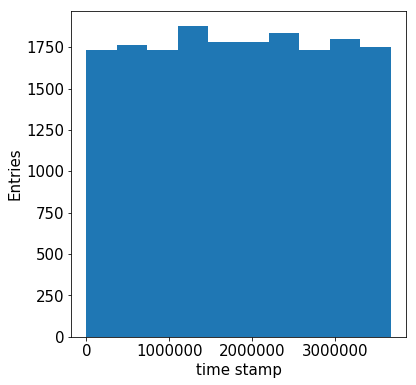

In [12]:
n, bins, patches = plt.hist(1e+3*(full.time - full.time[0]), 10)
labels("time stamp", "Entries")

In [13]:
st = [datetime.datetime.fromtimestamp(elem).strftime('%Y-%m-%d %H:%M:%S') for elem in full.time]
x = [datetime.datetime.strptime(elem, '%Y-%m-%d %H:%M:%S') for elem in st]

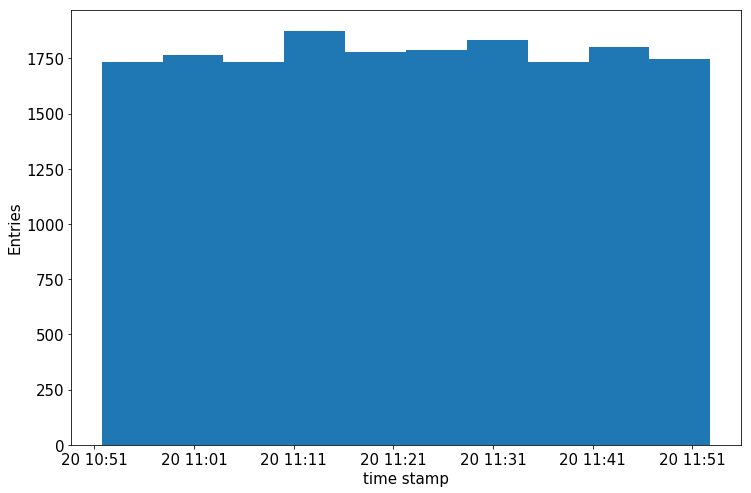

In [14]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1)
nx, bx, _ = plt.hist(x, 10)
labels("time stamp", "Entries")

In [15]:
st = datetime.datetime.fromtimestamp(full.time[-1:]).strftime('%Y-%m-%d %H:%M:%S')

In [16]:
print(st)

2017-04-20 11:52:50


In [17]:
print(full.time.index[-1])

17795


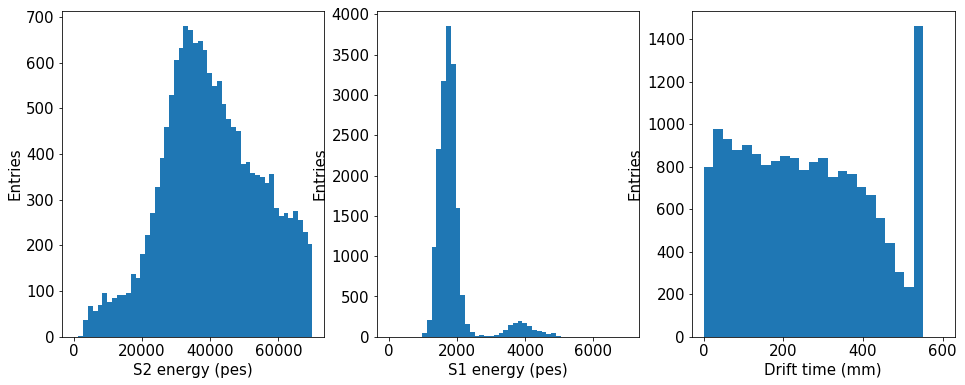

In [18]:
figsize=(16,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(full.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 2)
plt.hist(full.S1e, 50, (0e3,7e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(full.Z, 25, (0,600))
labels("Drift time (mm)", "Entries")


### Dependence with Z all alphas

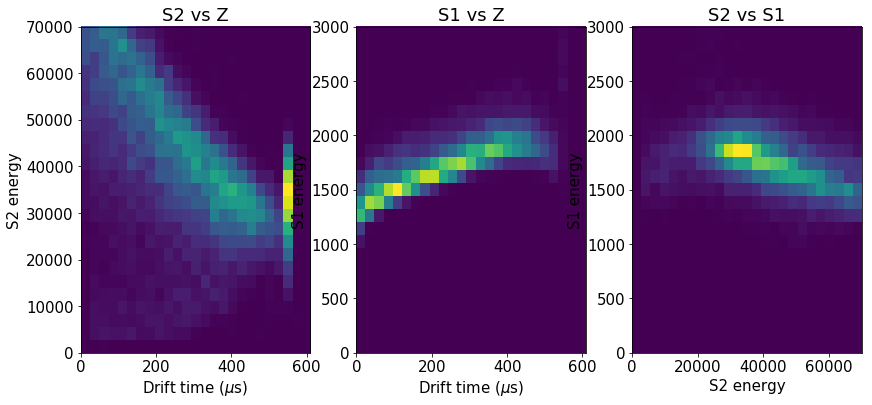

In [19]:
zrange =   0, 610
S2range = 0, 7e4
S1range = 0, 3e3

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(full.Z, full.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(full.Z, full.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(full.S2e, full.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')



### Fiducial volume

In [20]:
#core = blk[blk.R < 100]
core = full[full.R < 100]
print("Ratio wrt full:", len(core)/len(full))

Ratio wrt full: 0.2580355135985615


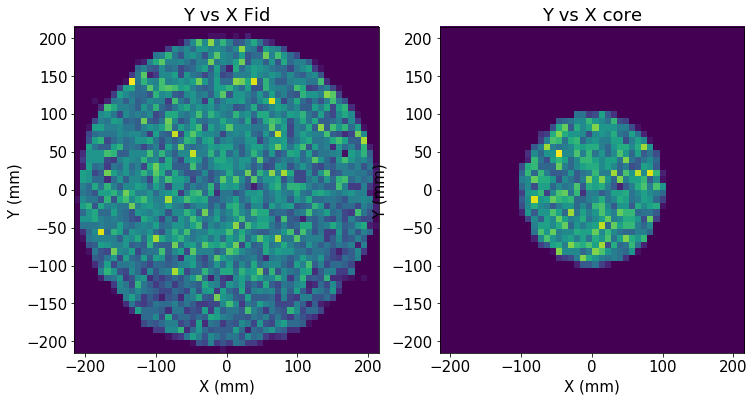

In [21]:
xrange = -215, 215
yrange = -215, 215

figsize=(12,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 2, 1)

plt.hist2d(full.X, full.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X Fid')

ax = plt.subplot(1, 2, 2)

plt.hist2d(core.X, core.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X core')

### Z correction for bulk 

#### S2

fit par[0] = 78222.10533979376 error = 1449.7938092796826
fit par[1] = -568.4251644374939 error = 24.092647894961022
degrees of freedom = 2
chi2 = 6.970995017736319


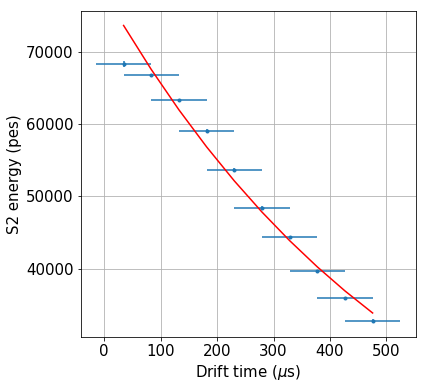

In [22]:
zrange =   10, 500
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(core.Z, core.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

#### Constrain fiducial in z

In [23]:
cz = core[in_range(core.Z ,25, 525)]
print("Ratio wrt full:", len(cz)/len(full))

Ratio wrt full: 0.21723982917509552


#### Fit S2 in fiducial 

fit par[0] = 78788.56546134899 error = 1405.6977600596215
fit par[1] = -557.8571734611587 error = 22.46370716935389
degrees of freedom = 2
chi2 = 6.191507693261281


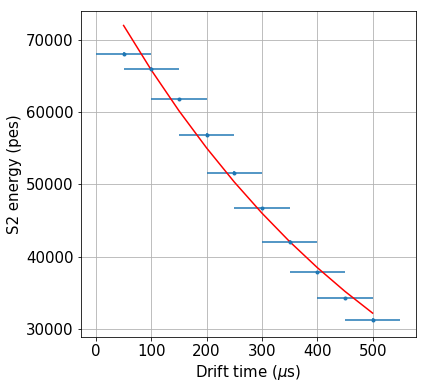

In [24]:
zrange =   25, 525
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(cz.Z, cz.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

### S2 corrections

In [25]:
st0 = time_from_timestamp(full.time[0])
st1 = time_from_timestamp(full.time[-1:])
print('t0 = {} t1 = {}'.format(st0,st1))

t0 = 2017-04-20 10:51:43 t1 = 2017-04-20 11:52:50


In [26]:
len(cz)

3866

using data set with length 3866
t0 = 2017-04-20 10:51:43 (index = 0) t1 = 2017-04-20 11:52:49 (index = 3866)
bin length = 1288
 ---fit over events between 0 and 1288
time0 = 2017-04-20 10:51:43 time1 = 2017-04-20 11:12:34
size of time leg = 1288
fit par[0] = 88038.08671658252 error = 510.23162834713446
fit par[1] = -503.5382731986412 error = 5.8485427048206615
degrees of freedom = 2
chi2 = 0.8387204902301062
 ---fit over events between 1288 and 2576
time0 = 2017-04-20 11:12:34 time1 = 2017-04-20 11:32:28
size of time leg = 1288
fit par[0] = 83992.24743009415 error = 896.787626542314
fit par[1] = -505.43715860224887 error = 10.166308723100833
degrees of freedom = 2
chi2 = 1.4394702190781585
 ---fit over events between 2576 and 3864
time0 = 2017-04-20 11:32:28 time1 = 2017-04-20 11:52:49
size of time leg = 1288
fit par[0] = 85221.01184329884 error = 1037.2470983010205
fit par[1] = -473.9888650814675 error = 10.8747341896601
degrees of freedom = 2
chi2 = 1.8071957432652679


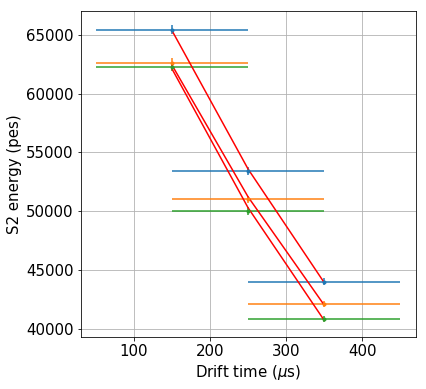

In [33]:
CHI2, LAMBDA, ELAMBDA, TSTAMP, TIME = lifetime(dst=cz, zrange=(100,400), Erange=(1e+3, 80e3), nbins=3)

In [34]:
plot_options()

In [35]:
TSTAMP

['2017-04-20 11:12:34', '2017-04-20 11:32:28', '2017-04-20 11:52:49']

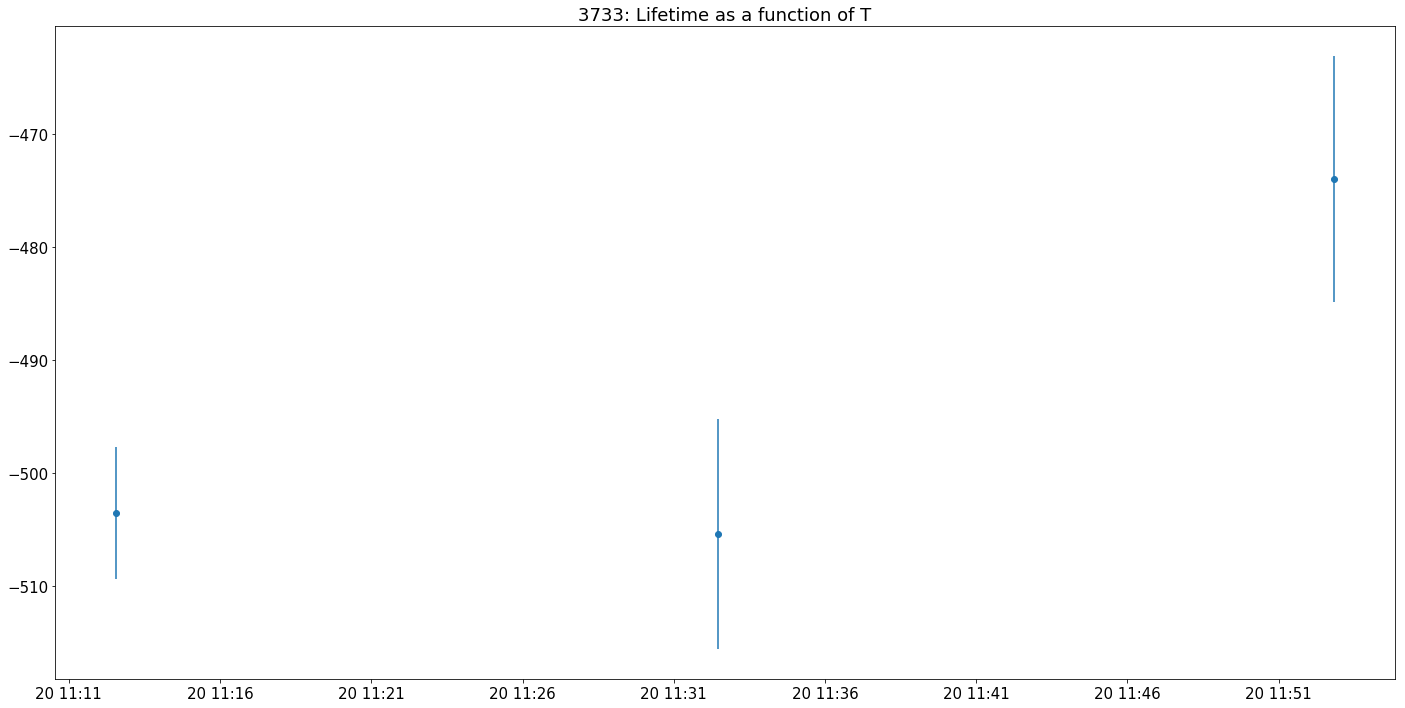

In [36]:
figsize=(24,12)
plt.figure(figsize=figsize)
plt.errorbar(TIME, LAMBDA, yerr=ELAMBDA, linestyle='none', fmt='o')
plt.title('{}: Lifetime as a function of T'.format(run_number))

In [31]:
#ppath = os.path.join(os.environ['IC_DATA'], 'LSC/logs/pressure/Plot_Log/GAS_Log_2017-04-17.txt')

In [32]:
#f = pd.read_csv(ppath, skiprows=2, sep=None)
#f
